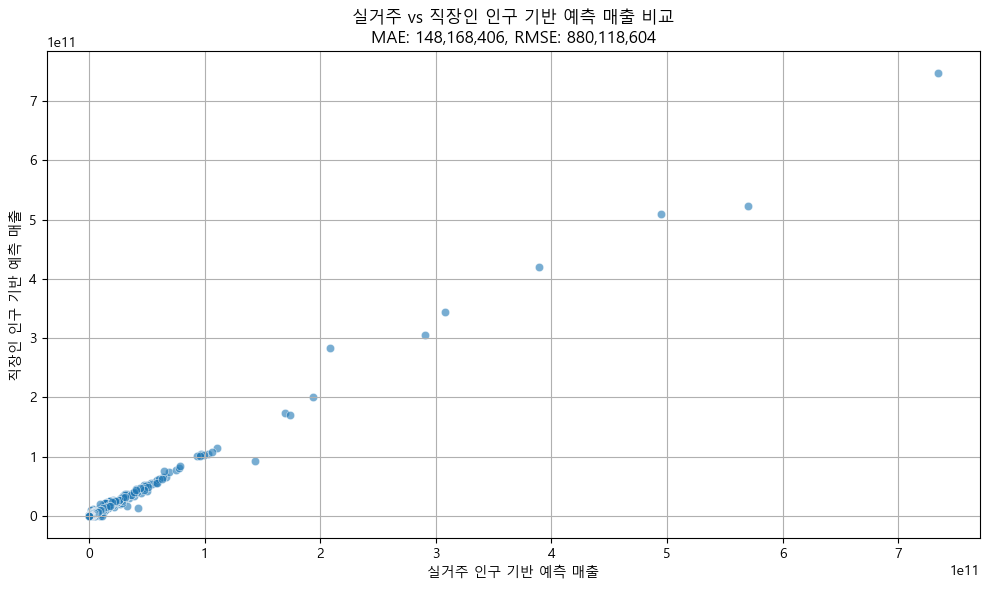

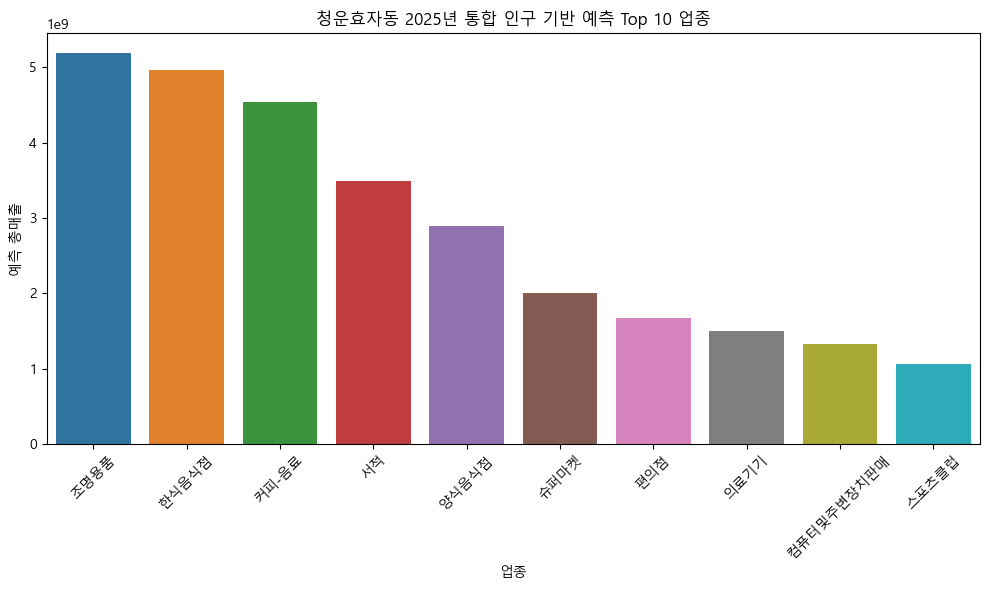

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정 (예: 윈도우 사용자는 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 파일 로드
local_df = pd.read_csv('./Data/Predicted_2025_Top_Business_LocalPeople_RF.csv')
work_df = pd.read_csv('./Data/Predicted_2025_Top_Business_Company.csv')

# 2. 행정동코드 문자열 통일
local_df['행정동코드'] = local_df['행정동코드'].astype(str).str.zfill(8)
work_df['행정동코드'] = work_df['행정동코드'].astype(str).str.zfill(8)

# 3. 공통 컬럼 기준 병합
merge_cols = ['연도', '행정동코드', '행정동명', '업종']
combined = pd.merge(
    local_df[merge_cols + ['예측_총매출']],
    work_df[merge_cols + ['예측_총매출']],
    on=merge_cols,
    suffixes=('_실거주', '_직장인')
)

# 4. 예측 평균값을 통한 통합
combined['예측_총매출'] = combined[['예측_총매출_실거주', '예측_총매출_직장인']].mean(axis=1)

# 5. 통합 순위 계산
combined['순위'] = combined.groupby('행정동코드')['예측_총매출'].rank(ascending=False, method='min')

# 6. 최종 정리된 결과
final_df = combined[['연도', '행정동코드', '행정동명', '업종', '예측_총매출', '순위']].sort_values(by=['행정동코드', '순위'])

# 7. 평가지표 계산
mae = np.mean(np.abs(combined['예측_총매출_실거주'] - combined['예측_총매출_직장인']))
rmse = np.sqrt(np.mean((combined['예측_총매출_실거주'] - combined['예측_총매출_직장인'])**2))

# 8. 전체 예측 비교 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=combined, 
    x='예측_총매출_실거주', 
    y='예측_총매출_직장인', 
    alpha=0.6
)
plt.title(f'실거주 vs 직장인 인구 기반 예측 매출 비교\nMAE: {mae:,.0f}, RMSE: {rmse:,.0f}')
plt.xlabel('실거주 인구 기반 예측 매출')
plt.ylabel('직장인 인구 기반 예측 매출')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. 특정 행정동코드 상위 업종 바그래프
dong_code = '11110515'  # 원하는 행정동코드로 바꾸기

if dong_code in final_df['행정동코드'].values:
    top10 = final_df[final_df['행정동코드'] == dong_code].sort_values(by='순위').head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top10, x='업종', y='예측_총매출')
    plt.title(f'{top10["행정동명"].iloc[0]} 2025년 통합 인구 기반 예측 Top 10 업종')
    plt.xticks(rotation=45)
    plt.ylabel('예측 총매출')
    plt.tight_layout()
    plt.show()
else:
    print(f"{dong_code}에 해당하는 데이터가 없습니다.")
